In [2]:
from Library.TEBD import *

In [3]:
pos_sq = gen_1d_pos_sequence(length=4, single_pos=[0,1,2], repeat_interval=1)
print(pos_sq)

[[0, 1, 2], [1, 2, 3], [1, 2, 3], [0, 1, 2]]


In [4]:
import torch as tc

In [5]:
h1 = tc.tensor([[1, 0], [0, -1]], dtype=tc.complex128)
h2 = tc.kron(h1, h1)
para = {
    'device': 'cpu',
    'dtype': tc.complex128,
}
P = tc.zeros([2, 2], device=para['device'], dtype=para['dtype'])
P[0, 0] = 1+0.j
sigma_x = tc.zeros([2, 2], device=para['device'], dtype=para['dtype'])
sigma_x[0, 1] = sigma_x[1, 0] = 1+0.j
hamilt = tc.kron(P, tc.kron(sigma_x, P))
hamilt = hamilt.reshape([2]*6)
pos_sq = gen_1d_pos_sequence(length=5, single_pos=[0,1,2], repeat_interval=1)
Hamiltonian = {
    'Hi': [hamilt],
    'pos': [pos_sq],
    }

In [6]:
import Library.TensorNetwork as TN

In [7]:
init_states = TN.rand_mps_pack(2, length=5, chi=16, phydim=2)
for node in init_states.node_list:
    print(node.shape)
print(init_states.chi)
result = TEBD(Hamiltonian=Hamiltonian, tau=0.02, time_tot=0.1, print_time=0.02, init_mps=init_states, obs=[])

torch.Size([2, 1, 2, 2])
torch.Size([2, 2, 2, 4])
torch.Size([2, 4, 2, 4])
torch.Size([2, 4, 2, 2])
torch.Size([2, 2, 2, 1])
16


## Test TN_WorkFlow.TimeEvol.PXP_mul_states_evol()

In [8]:
from TN_WorkFlow.TimeEvol import PXP_mul_states_evol as PXP_mps

In [9]:
para = {
    'length': 5,
    'tau': 0.02,
    'time_tot': 0.1,
    'print_time': 0.02,
    'device': tc.device('cpu')
}
evol_mps = PXP_mps(init_states, para)

mps态的是否模为1

In [10]:
mps = evol_mps[2]
mps.merge_all()

In [11]:
print(mps.node_list[0].shape)
a = mps.node_list[0].reshape((2, -1))
print(tc.einsum('ni, ni -> n', a, a.conj()))

torch.Size([2, 1, 2, 2, 2, 2, 2, 1])
tensor([1.0000+0.j, 1.0000+0.j])


对比不使用mps的演化结果

In [12]:
from WorkFlow.TimeEvol import PXP_mul_states_evl as PXP_states
from WorkFlow.InitStates import rand_states, rand_dir_prod_states

In [13]:
length = 10
number = 7
dtype = tc.complex64
device = tc.device('cpu')
init_states = rand_dir_prod_states(length=length, number=number, dtype=dtype, device=device)
init_mps = TN.TensorTrain_pack(tensor_packs=[init_states], length=length, phydim=2, chi=None, device=device, dtype=dtype, initialize=True)

torch.Size([7, 1024])


In [14]:
mps_copy = TN.copy_from_mps_pack(init_mps)
mps_copy.merge_all()
print(mps_copy.node_list[0].shape)
print(tc.dist(mps_copy.node_list[0].squeeze(), init_states))

torch.Size([7, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
tensor(1.7219e-06)


In [15]:
para = {
    'length': length,
    'tau': 0.02,
    'time_tot': 0.2,
    'print_time': 0.02,
    'device': tc.device('cpu')
}

In [16]:
import time
length_list = [i for i in range(6, 21)]
t_normal = []
t_mps = []
number = 1
device = tc.device('cuda:0')
for length in length_list:
    para['length'] = length
    init_states = rand_dir_prod_states(length=length, number=number, dtype=dtype, device=device)
    init_mps = TN.TensorTrain_pack(tensor_packs=[init_states], length=length, phydim=2, chi=None, device=device, dtype=dtype, initialize=True)
    t1 = time.time()
    evol_states = PXP_states(states=init_states, para=para)
    t2 = time.time()
    evol_mps = PXP_mps(states=init_mps, para=para)
    t3 = time.time()
    print('-'*20)
    print('length=', length)
    print('without TEBD', t2-t1)
    print('TEBD', t3-t2)
    t_normal.append(t2-t1)
    t_mps.append(t3-t2)

torch.Size([1, 64])


--------------------
length= 6
without TEBD 0.010209321975708008
TEBD 0.6068511009216309
torch.Size([1, 128])
--------------------
length= 7
without TEBD 0.003671407699584961
TEBD 1.2152578830718994
torch.Size([1, 256])
--------------------
length= 8
without TEBD 0.004674434661865234
TEBD 2.2635011672973633
torch.Size([1, 512])
--------------------
length= 9
without TEBD 0.005209684371948242
TEBD 4.061081171035767
torch.Size([1, 1024])
--------------------
length= 10
without TEBD 0.00706791877746582
TEBD 4.233914136886597
torch.Size([1, 2048])
--------------------
length= 11
without TEBD 0.007269144058227539
TEBD 9.884853839874268
torch.Size([1, 4096])
--------------------
length= 12
without TEBD 0.012202262878417969
TEBD 36.51603555679321
torch.Size([1, 8192])
--------------------
length= 13
without TEBD 0.051116943359375
TEBD 76.65918684005737
torch.Size([1, 16384])
--------------------
length= 14
without TEBD 0.6997823715209961
TEBD 145.0959599018097
torch.Size([1, 32768])
---------

In [ ]:
print(type(evol_mps))
print(evol_mps[0])
print(type(evol_states))
print(evol_states.shape)

<class 'list'>
<class 'torch.Tensor'>
torch.Size([7, 50, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


态演化的误差

In [ ]:
a = TN.copy_from_mps_pack(evol_mps[0])
a.merge_all()
a = a.node_list[0]
print(a.shape)
b = evol_states.select(dim=1, index=0)
print(b.shape)
print(tc.dist(a.squeeze(), b))

torch.Size([7, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
torch.Size([7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor(6.6369e-06)


Test TensorNetwork.one_body_obs_from_mps_pack()

In [ ]:
# init_states = TN.rand_mps_pack(3, length=5, chi=16, phydim=2, dtype=tc.complex128)
spins = []
sx = tc.tensor([[0, 1], [1, 0]], dtype=dtype) * 0.5
sy = tc.tensor([[0, -1.j], [1.j, 0]], dtype=dtype) * 0.5
sz = tc.tensor([[1, 0], [0, -1]], dtype=dtype) * 0.5
spins = [sx, sy, sz]
mags = TN.multi_mags_from_mps_pack(init_mps, spins)

mags_ = TN.one_body_obs_from_mps_pack(init_mps, spins)
print(tc.dist(mags, mags_))

tensor(6.8805e-06)


测试演化中磁矩的误差

In [ ]:
from Library.PhysModule import multi_mags_from_states

In [ ]:
mags_error = []
mag_x_0_normal = []
mag_x_0_mps = []
for i in range(len(evol_mps)):
    mags_mps = TN.one_body_obs_from_mps_pack(evol_mps[i], obs=spins)
    mags_normal = multi_mags_from_states(evol_states.select(dim=1, index=i))
    mag_x_0_mps.append(mags_mps.real[0,0,0])
    mag_x_0_normal.append(mags_normal.real[0,0,0])
    # print(mags_mps.shape)
    # print(mags_normal.shape)
    # print(tc.dist(mags_mps, mags_normal))
    mags_error.append(tc.dist(mags_mps, mags_normal)/number)

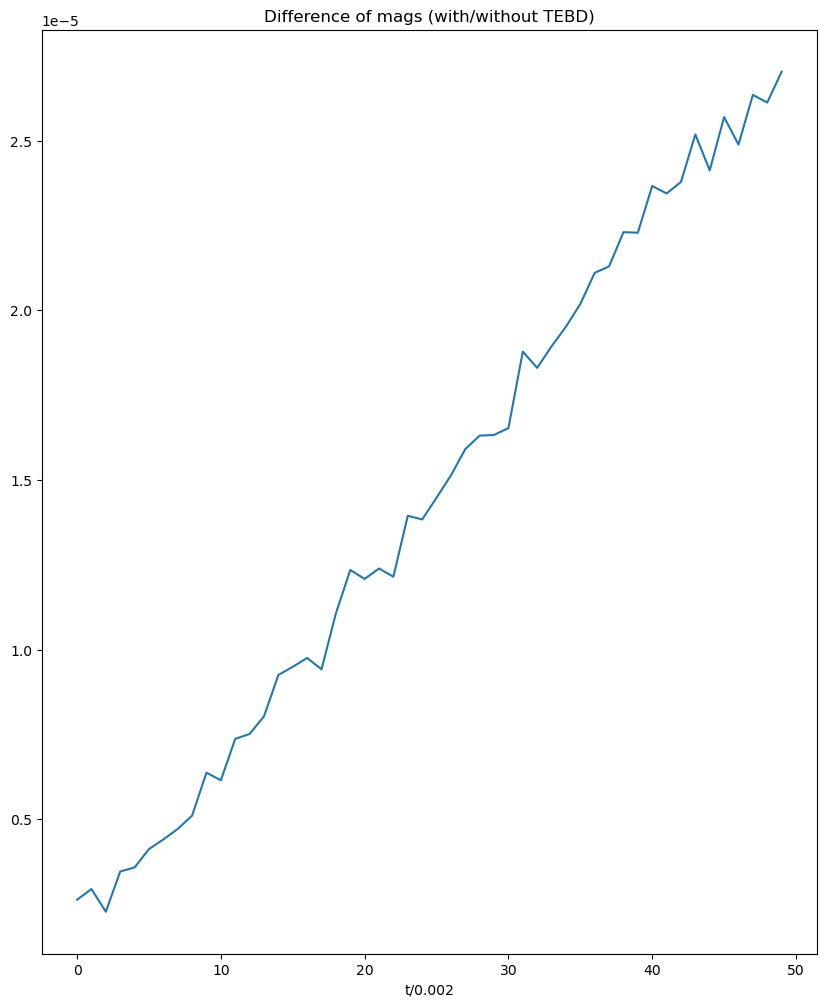

In [ ]:
# 画图
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 12))
ax = fig.gca()
ax.plot(mags_error)
ax.set_title('Difference of mags (with/without TEBD)')
ax.set_xlabel('t/0.002')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 1))
# ax.set_ylabel()
plt.show()

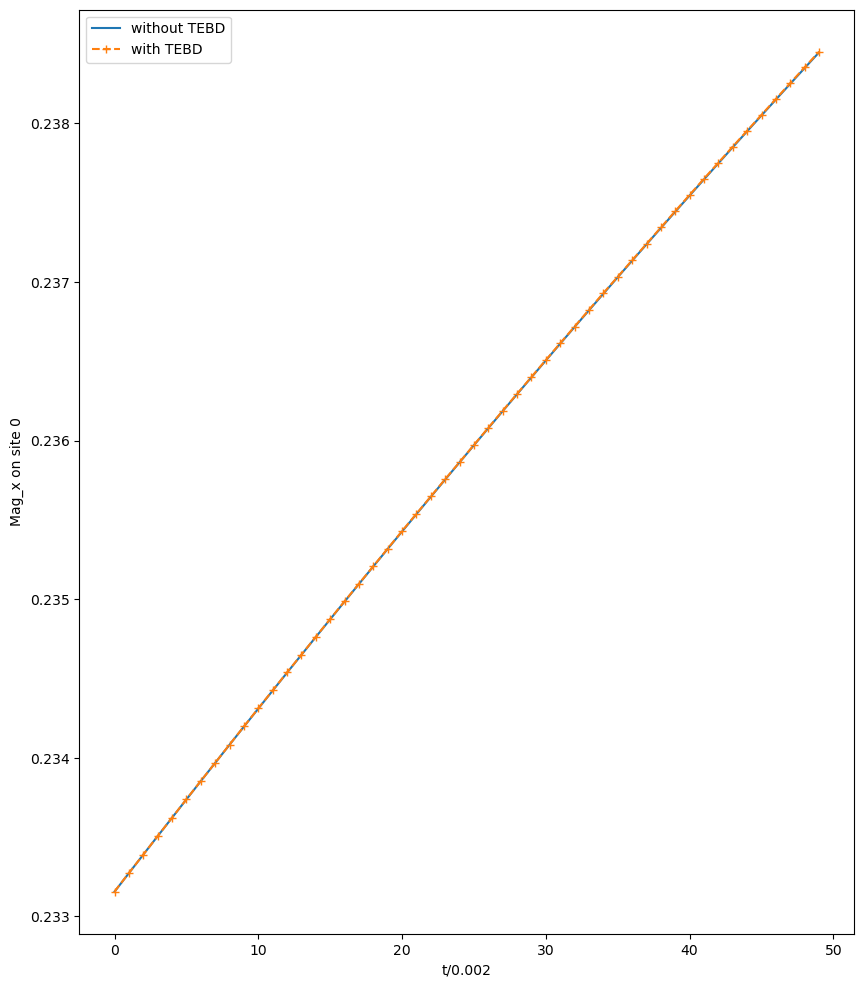

In [ ]:
fig_evol = plt.figure(figsize=(10, 12))
ax_evol = fig_evol.gca()
ax_evol.set_xlabel('t/0.002')
ax_evol.set_ylabel('Mag_x on site 0')
ax_evol.plot(mag_x_0_normal, label='without TEBD')
ax_evol.plot(mag_x_0_mps, label='with TEBD', marker='+', linestyle='dashed')
ax_evol.legend()
plt.show()